In [1]:
"""  Import necessary packages """

import os
import rioxarray as rxr
import LoadSaveFunctions as lsf
import matplotlib.pyplot as plt
import numpy as np
import ipyleaflet
import ipywidgets as ipw
from pyproj import CRS, Transformer
from matplotlib.ticker import FixedLocator

In [2]:
""" Load and check raster file using rioxarray package"""

file_path = lsf.load_file()
try:
    data = rxr.open_rasterio(file_path, masked=True)
    print("Geotiff file loaded successfully.")
    print(data)
except Exception as e:
    print(f"Error loading the Geotiff file: {e}")

# View generate metadata associated with the raster file
print("The crs of your data is:", data.rio.crs)
print("The nodatavalue of your data is:", data.rio.nodata)
print("The shape of your data is:", data.shape)
print("The spatial resolution for your data is:", data.rio.resolution())
print("The metadata for your data is:", data.attrs)
print("The spatial extent of this data is: ", data.rio.bounds())

Selected file: /home/grominou/Documents/Recherche/Ressources_geochimie/Isotope_raster_maps/USA_Sr/USSr_Rock.tif
Geotiff file loaded successfully.
<xarray.DataArray (band: 1, y: 2850, x: 4532)> Size: 52MB
[12916200 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 36kB -2.031e+06 -2.03e+06 ... 2.499e+06 2.5e+06
  * y            (y) float64 23kB 7.324e+05 7.314e+05 ... -2.116e+06 -2.117e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:       Area
    STATISTICS_MAXIMUM:  0.81528428430032
    STATISTICS_MEAN:     0.71334775874571
    STATISTICS_MINIMUM:  0.70396000146866
    STATISTICS_STDDEV:   0.0079878668372943
    scale_factor:        1.0
    add_offset:          0.0
The crs of your data is: PROJCS["unknown",GEOGCS["unknown",DATUM["Unknown based on Normal Sphere (r=6370997) ellipsoid",SPHEROID["Normal Sphere (r=6370997)",6370997,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJE

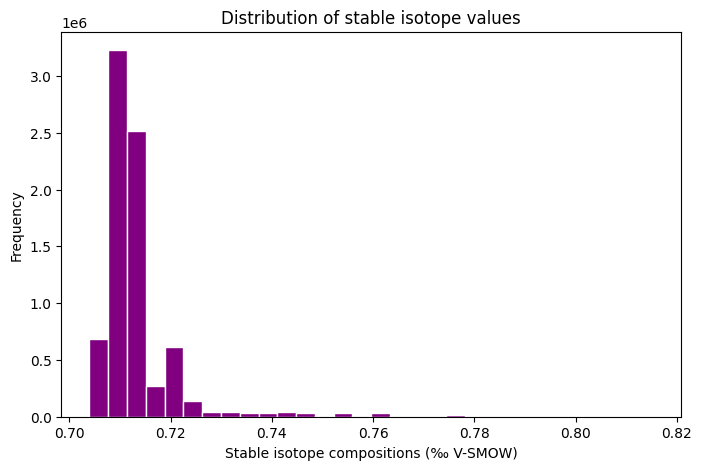

The minimum raster value is:  0.70396
The maximum raster value is:  0.8152843


In [3]:
""" Plot histogram of values from the previously loaded raster file """

f, ax = plt.subplots(figsize=(8, 5))
data.plot.hist(ax=ax, color="purple", bins=30, edgecolor='white')
ax.set(title="Distribution of stable isotope values",
       xlabel='Stable isotope compositions (‰ V-SMOW)',
       ylabel='Frequency')
plt.show()

print("The minimum raster value is: ", np.nanmin(data.data))
print("The maximum raster value is: ", np.nanmax(data.data))

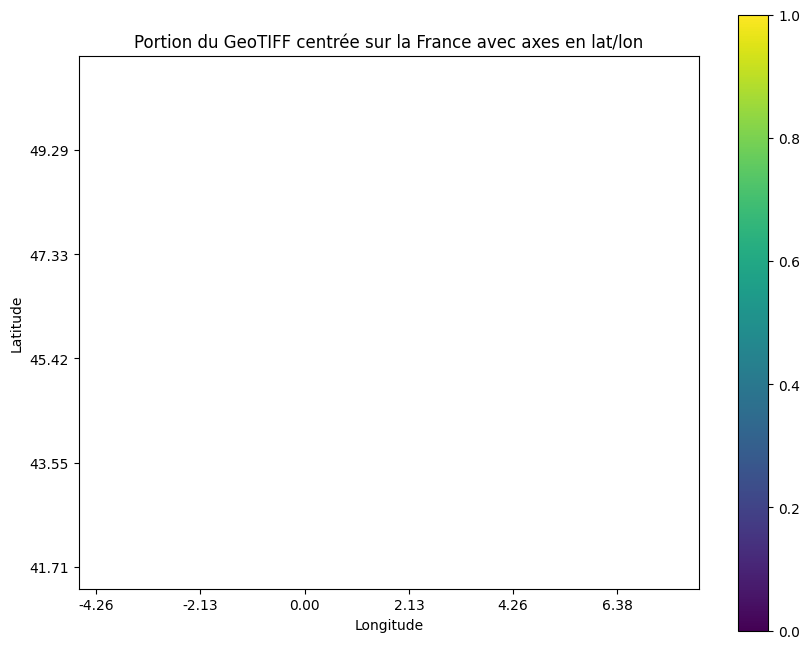

In [4]:
""" Plot a limited area of the raster """

# Definition of the GeoTIFF projection (ESRI:54012) and WGS 84 (latitude/longitude)
crs_mollweide = CRS.from_string('ESRI:54012')  # CRS for Mollweide
crs_wgs84 = CRS.from_epsg(4326)  # CRS for WGS 84 (EPSG:4326)

# Create a transformer for coordinate conversion
transformer_to_wgs84 = Transformer.from_crs(crs_mollweide, crs_wgs84, always_xy=True)
transformer_to_mollweide = Transformer.from_crs(crs_wgs84, crs_mollweide, always_xy=True)

# France geographic limits in WGS 84 (longitude, latitude)
# lon_min, lon_max = -5.14, 9.56
# lat_min, lat_max = 41.33, 51.09

# USA geographic limits
lon_min, lon_max = -179.1489, -66.93457
lat_min, lat_max = 24.3963, 49.3843


# Coordinate conversion from WGS 84 (lon/lat) to Mollweide (x/y)
x_min, y_min = transformer_to_mollweide.transform(lon_min, lat_min)
x_max, y_max = transformer_to_mollweide.transform(lon_max, lat_max)

# Filter Geotiff data with selected coordinates
subset = data.sel(x=slice(x_min, x_max), y=slice(y_max, y_min))

# Create a plot
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(subset[0], origin='upper', extent=[x_min, x_max, y_min, y_max], cmap='viridis')

# Definition of the ticks and conversion to latitude/longitude
def update_ticks(ax, transformer, axis='x'):
    # Recover existing ticks
    ticks = ax.get_xticks() if axis == 'x' else ax.get_yticks()

    # Transform ticks to lat/lon
    new_labels = []
    for tick in ticks:
        lon, lat = transformer.transform(tick, 0) if axis == 'x' else transformer.transform(0, tick)
        new_labels.append(lon if axis == 'x' else lat)

    # Set ticks place and their label
    if axis == 'x':
        ax.xaxis.set_major_locator(FixedLocator(ticks))
        ax.set_xticklabels([f"{lon:.2f}" for lon in new_labels])
    else:
        ax.yaxis.set_major_locator(FixedLocator(ticks))
        ax.set_yticklabels([f"{lat:.2f}" for lat in new_labels])

# Update axes x and y with new coordinates
update_ticks(ax, transformer_to_wgs84, axis='x')  # Pour l'axe des x (longitude)
update_ticks(ax, transformer_to_wgs84, axis='y')  # Pour l'axe des y (latitude)

# Add label to axes
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Display color bar and figure
plt.colorbar(im, ax=ax)
plt.title('Geotiff of a limited area')
plt.show()


In [ ]:
""" Create a map from openstreetmap centered on given coordinates (latitude, longitude) that we can browse and click to get coordinates """

# Defining global variables to store latitude, longitude and marker state
lat = None
lon = None
current_marker = None
srvalue = None
srerror = None

# Load strotium raster files (values and s.e.)
folder_path = lsf.load_folder()
file1 = os.path.join(folder_path, '')+"GlobalSr.tif"
file2 = os.path.join(folder_path, '')+"GlobalSr_se.tif"
dataset = rxr.open_rasterio(file1, masked=True)
dataerror = rxr.open_rasterio(file2, masked=True)

# Create map centered on given coordiantes
center = [45.7586, 4.8333]  # Lyon
mymap = ipyleaflet.Map(basemap=ipyleaflet.basemaps.Esri.WorldStreetMap, center=center, zoom=3, layout=ipw.Layout(width='1000px', height='600px'), scroll_wheel_zoom = True)


# HTML widget to display coordinates
coord_label = ipw.HTML("Click on map to get coordiantes")
coord_label.value = "Coordinates : "

# Function to get coordinates by clicking on the map
def on_map_interaction(**kwargs):
    global lat, lon, current_marker, srvalue, srerror
    if kwargs.get('type') == 'click':
        lat, lon = kwargs.get('coordinates')
        proj = Transformer.from_crs("EPSG:4326", dataset.rio.crs, always_xy=True)
        x, y = proj.transform(lon, lat)
        srvalue = dataset.sel(x=x, y=y, method="nearest")
        srerror = dataerror.sel(x=x, y=y, method="nearest")
        coord_label.value = f"Coordonnées : Latitude {round(lat, 2)}, Longitude {round(lon, 2)} ; 87Sr/86Sr = {round(float(srvalue.values), 4)}±{round(float(srerror.values), 4)}"

        # Remove existing current marker
        if current_marker is not None:
            mymap.remove_layer(current_marker)
        
        # Create new marker on click position
        current_marker = ipyleaflet.Marker(location=(lat, lon))
        mymap.add_layer(current_marker)

# link interaction event with function
mymap.on_interaction(on_map_interaction)

# Display map and widget
ui = ipw.VBox([coord_label, mymap])
ui


